In [1]:
import timm
import numpy as np
import torch
import torchvision
import pickle
import math
from tqdm import tqdm
from typing import Callable, Iterator, List, Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torchvision import datasets, transforms
from sklearn.metrics import mean_absolute_error, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import cv2
import os
import torch.nn.functional as F
from PIL import Image
from pathlib import Path
from matplotlib.colors import ListedColormap
from torchvision.models.feature_extraction import get_graph_node_names
import copy



data_path = './dtd/dtd/dtd/images/'

In [2]:

dir = "dtd"
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data = datasets.dtd.DTD(root=dir,
                        transform=data_transforms)
dataloader = DataLoader(data, batch_size=32, shuffle=True)
num_classes = len(data.classes)
paths = data._image_files


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

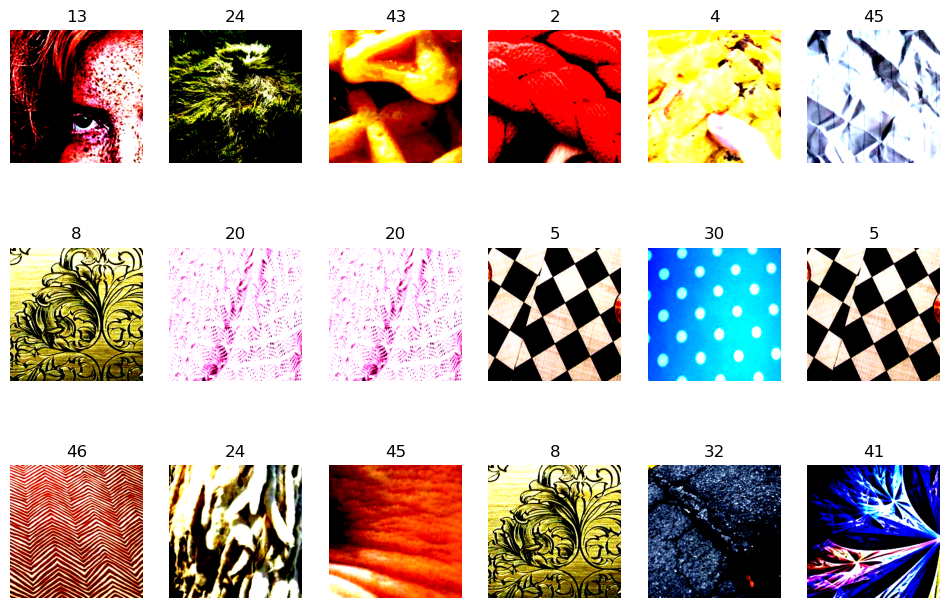

In [66]:
images_, labels_ = next(iter(dataloader))

figure = plt.figure(figsize=(12, 8))
cols, rows = 6, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(images_), size=(1,)).item()
    img, label, path = images_[sample_idx], labels_[sample_idx], paths[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f"{label}")
    plt.axis("off")
    plt.imshow(img.squeeze().permute(1, 2, 0))
plt.show()

In [3]:
model = timm.create_model("hf_hub:anonauthors/dtd-timm-convnext_base.fb_in1k", pretrained=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RAdam(model.parameters(), lr=0.001)
model.eval()

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=128, out_features=384, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=128, out_features=128, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU(approximate='none')
            (

In [5]:
model.eval()
val_running_loss = 0.0
val_correct_predictions = 0
val_total_samples = 0
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in dataloader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs, labels)

    val_running_loss += loss.item() * images.size(0)
    # Calculate accuracy
    _, predicted = torch.max(outputs, 1)
    val_correct_predictions += (predicted == labels).sum().item()
    val_total_samples += labels.size(0)
         
    all_preds.extend(predicted.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
        
val_epoch_loss = val_running_loss / val_total_samples
val_epoch_accuracy = val_correct_predictions / val_total_samples

print('Loss:', val_epoch_loss)
print('Accuracy:', val_epoch_accuracy)

Loss: 0.3948972494262172
Accuracy: 0.9212765957446809


In [4]:
from timm.models.layers import trunc_normal_, DropPath

class Block(nn.Module):
    def __init__(self, dim, drop_path=0., layer_scale_init_value=1e-6):
        super().__init__()
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim) # depthwise conv
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pwconv1 = nn.Linear(dim, 4 * dim) # pointwise/1x1 convs, implemented with linear layers
        self.act = nn.GELU()
        self.pwconv2 = nn.Linear(4 * dim, dim)
        self.gamma = nn.Parameter(layer_scale_init_value * torch.ones((dim)), 
                                    requires_grad=True) if layer_scale_init_value > 0 else None
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()

    def forward(self, x):
        input = x
        x = self.dwconv(x)
        x = x.permute(0, 2, 3, 1) # (N, C, H, W) -> (N, H, W, C)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        if self.gamma is not None:
            x = self.gamma * x
        x = x.permute(0, 3, 1, 2) # (N, H, W, C) -> (N, C, H, W)

        x = input + self.drop_path(x)
        return x

class ConvNeXt(nn.Module):
    def __init__(self, in_chans=3, num_classes=num_classes, 
                 depths=[3, 3, 9, 3], dims=[192, 384, 768, 1024], drop_path_rate=0., 
                 layer_scale_init_value=1e-6, head_init_scale=1.,
                 ):
        super().__init__()

        self.downsample_layers = nn.ModuleList() # stem and 3 intermediate downsampling conv layers
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm(dims[0], eps=1e-6, data_format="channels_first")
        )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, data_format="channels_first"),
                    nn.Conv2d(dims[i], dims[i+1], kernel_size=2, stride=2),
            )
            self.downsample_layers.append(downsample_layer)

        self.stages = nn.ModuleList() # 4 feature resolution stages, each consisting of multiple residual blocks
        dp_rates=[x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))] 
        cur = 0
        for i in range(4):
            stage = nn.Sequential(
                *[Block(dim=dims[i], drop_path=dp_rates[cur + j], 
                layer_scale_init_value=layer_scale_init_value) for j in range(depths[i])]
            )
            self.stages.append(stage)
            cur += depths[i]

        self.norm = nn.LayerNorm(dims[-1], eps=1e-6) # final norm layer
        self.head = nn.Linear(dims[-1], num_classes)

        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)
        self.stored_gradients = None  # Tensor to store gradients

    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            trunc_normal_(m.weight, std=.02)
            nn.init.constant_(m.bias, 0)

    def save_gradients(self, grad):
        self.stored_gradients = grad  # Store gradients as tensor

    def get_activations_gradient(self):
        return self.stored_gradients  # Return the stored gradients
    
    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        return self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)
    
    def get_activations(self, x):
        activations = []
        for i in range(4):  # Assuming there are 4 downsampling layers
            x = self.downsample_layers[i](x)
            if i == 3:
                activations.append(x.clone().detach())  # Clone and detach to avoid modifying original gradients
            x = self.stages[i](x)
        return activations
    
    def forward(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            if i == 3:  # Register hook on the output tensor of the last convolutional layer
                x.register_hook(self.save_gradients)
            x = self.stages[i](x)
        x = self.norm(x.mean([-2, -1])) # global average pooling, (N, C, H, W) -> (N, C)
        x = self.head(x)
        return x
    
    # def attach_last_conv_hook(self):
    #     # Attach the hook to the last convolutional layer in downsample_layers
    #     last_conv_layer = self.downsample_layers[-1][-1] # Assuming the last element in downsample_layer is the last conv layer
    #     last_conv_layer.register_hook(self.save_gradients)
        
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-6, data_format="channels_last"):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(normalized_shape))
        self.bias = nn.Parameter(torch.zeros(normalized_shape))
        self.eps = eps
        self.data_format = data_format
        if self.data_format not in ["channels_last", "channels_first"]:
            raise NotImplementedError 
        self.normalized_shape = (normalized_shape, )
    
    def forward(self, x):
        if self.data_format == "channels_last":
            return F.layer_norm(x, self.normalized_shape, self.weight, self.bias, self.eps)
        elif self.data_format == "channels_first":
            u = x.mean(1, keepdim=True)
            s = (x - u).pow(2).mean(1, keepdim=True)
            x = (x - u) / torch.sqrt(s + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x


In [5]:
custom_model = ConvNeXt().to(device)

# Load pretrained weights
pre_trained_model = 'anonauthors/dtd-timm-convnext_base.fb_in1k'
pretrained_state_dict = torch.hub.load_state_dict_from_url(
        f'https://huggingface.co/{pre_trained_model}/resolve/main/pytorch_model.bin'
    )
custom_model.load_state_dict(pretrained_state_dict, strict=False)

_IncompatibleKeys(missing_keys=['downsample_layers.0.0.weight', 'downsample_layers.0.0.bias', 'downsample_layers.0.1.weight', 'downsample_layers.0.1.bias', 'downsample_layers.1.0.weight', 'downsample_layers.1.0.bias', 'downsample_layers.1.1.weight', 'downsample_layers.1.1.bias', 'downsample_layers.2.0.weight', 'downsample_layers.2.0.bias', 'downsample_layers.2.1.weight', 'downsample_layers.2.1.bias', 'downsample_layers.3.0.weight', 'downsample_layers.3.0.bias', 'downsample_layers.3.1.weight', 'downsample_layers.3.1.bias', 'stages.0.0.gamma', 'stages.0.0.dwconv.weight', 'stages.0.0.dwconv.bias', 'stages.0.0.norm.weight', 'stages.0.0.norm.bias', 'stages.0.0.pwconv1.weight', 'stages.0.0.pwconv1.bias', 'stages.0.0.pwconv2.weight', 'stages.0.0.pwconv2.bias', 'stages.0.1.gamma', 'stages.0.1.dwconv.weight', 'stages.0.1.dwconv.bias', 'stages.0.1.norm.weight', 'stages.0.1.norm.bias', 'stages.0.1.pwconv1.weight', 'stages.0.1.pwconv1.bias', 'stages.0.1.pwconv2.weight', 'stages.0.1.pwconv2.bias', 

In [6]:
def generate_heatmap(model, img):
    pred = model(img)
    dimension = int(pred.argmax(dim=1)[0])
    pred[:, dimension].backward()
    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=(0, 2, 3))
    activations = custom_model.get_activations(img)
    pooled_gradients = pooled_gradients.detach()
    activations = model.get_activations(img)
    for i in range(len(activations)):
        activations[i] = activations[i].detach() * pooled_gradients[i] 
    stacked_activations = torch.stack(activations)  # Stack the tensors
    heatmap = torch.mean(stacked_activations, dim=1).squeeze()
    heatmap = torch.clamp(heatmap, min=0)  # Ensure non-negative values
    heatmap /= torch.max(heatmap)  # Normalize
    return heatmap

def save_heatmap(heatmap, idx, output_folder):
    heatmap = heatmap.cpu()
    plt.matshow(heatmap.squeeze())
    path_save = os.path.join(output_folder, f"heatmap_raw_{idx}.pdf")
    plt.savefig(path_save)
    plt.close()

def superimpose_and_save(heatmap, img, idx, output_folder):
    heatmap = torch.mean(heatmap, dim=0).squeeze().cpu().numpy()  # Shape: (7, 7)
    img = img.permute(1, 2, 0).cpu().numpy()  # Convert to (H, W, C)
    # Normalize heatmap to [0, 255] and convert to uint8
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap)))
    
    # Ensure img is in range [0, 255] and convert to uint8
    img = np.uint8(255 * (img - np.min(img)) / (np.max(img) - np.min(img)))
    # Apply color map to heatmap
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Superimpose heatmap on image
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_colored, 0.4, 0)
    # Save the superimposed image
    img_path = Path(str(paths[idx]))
    filename_without_extension = img_path.stem
    full_path = os.path.join(output_folder, filename_without_extension + '.jpg')
    cv2.imwrite(full_path, superimposed_img)

In [4]:
misclassified_indices = []
misclassified_images = []
misclassified_labels = []

model.eval()
with torch.no_grad():
    for idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(images.size(0)):
            if preds[i] != labels[i]:
                misclassified_indices.append(idx * dataloader.batch_size + i)
                misclassified_images.append(images[i])
                misclassified_labels.append(labels[i])


In [125]:
output_folder = "./outputs_gradcam"
os.makedirs(output_folder, exist_ok=True)
count = 0
custom_model.to(device)
for idx, img in zip(misclassified_indices, misclassified_images):
    count += 1
    img = img.unsqueeze(0)  # Add batch dimension
    img.to(device)
    custom_model.eval()
    heatmap = generate_heatmap(custom_model, img)
    # save_heatmap(heatmap, idx, output_folder)
    superimpose_and_save(heatmap, img[0], idx, output_folder)
    

Integrated Gradients

In [97]:
def pre_processing(obs, device):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    obs = obs / 255
    obs = (obs - mean) / std
    obs = np.transpose(obs, (2, 0, 1))
    obs = np.expand_dims(obs, 0)
    obs = np.array(obs)
    obs_tensor = torch.tensor(obs, dtype=torch.float32, device=device, requires_grad=True)
    return obs_tensor

In [55]:
def calculate_outputs_and_gradients(inputs, model, target_label_idx, device):
    # do the pre-processing
    predict_idx = None
    gradients = []
    for input in inputs:
        input = pre_processing(input, device)
        input.to(device)
        output = model(input)
        if target_label_idx is None:
            target_label_idx = torch.argmax(output, 1).item()
        output = F.softmax(output, dim=1)
        index = np.ones((output.size()[0], 1)) * target_label_idx
        index = torch.tensor([[target_label_idx]], dtype=torch.int64, device=device)
        output = output.gather(1, index)
        # clear grad
        model.zero_grad()
        output.backward()
        gradient = input.grad.detach().cpu().numpy()[0]
        gradients.append(gradient)
    gradients = np.array(gradients)
    return gradients, target_label_idx

In [112]:
def integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, baseline=None, steps=50, device="cpu"):
    if baseline is None:
        baseline = 0 * inputs 
    # scale inputs and compute gradients
    scaled_inputs = [baseline + (float(i) / steps) * (inputs - baseline) for i in range(0, steps + 1)]
    grads, _ = predict_and_gradients(scaled_inputs, model, target_label_idx, device)
    avg_grads = np.average(grads[:-1], axis=0)
    avg_grads = np.transpose(avg_grads, (1, 2, 0))
    delta_X = (pre_processing(inputs, device) - pre_processing(baseline, device)).detach().squeeze(0).cpu().numpy()
    delta_X = np.transpose(delta_X, (1, 2, 0))
    integrated_grad = delta_X * avg_grads
    return integrated_grad

def random_baseline_integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, steps, num_random_trials, device):
    all_intgrads = []
    for i in range(num_random_trials):
        integrated_grad = integrated_gradients(inputs, model, target_label_idx, predict_and_gradients, \
                                                baseline=255.0 *np.random.random(inputs.shape), steps=steps, device=device)
        all_intgrads.append(integrated_grad)
        # print('the trial number is: {}'.format(i))
    avg_intgrads = np.average(np.array(all_intgrads), axis=0)
    return avg_intgrads

In [108]:

def generate_entrie_images(img_origin, img_integrad, img_integrad_overlay):
    blank = np.ones((img_origin.shape[0], 10, 3), dtype=np.uint8) * 255
    # blank_hor = np.ones((10, 20 + img_grad.shape[0] * 3, 3), dtype=np.uint8) * 255
    # upper = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_grad_overlay, blank, img_grad], 1)
    down = np.concatenate([img_origin[:, :, (2, 1, 0)], blank, img_integrad_overlay, blank, img_integrad], 1)
    # print(upper.shape, blank_hor.shape, down.shape)
    total = np.concatenate([down], 0)
    total = cv2.resize(total, (550, 182))

    return total

In [11]:
G = [0, 255, 0]
R = [255, 0, 0]

def convert_to_gray_scale(attributions):
    return np.average(attributions, axis=2)

In [12]:
def compute_threshold_by_top_percentage(attributions, percentage=60, plot_distribution=True):
    if percentage < 0 or percentage > 100:
        raise ValueError('percentage must be in [0, 100]')
    if percentage == 100:
        return np.min(attributions)
    flat_attributions = attributions.flatten()
    attribution_sum = np.sum(flat_attributions)
    sorted_attributions = np.sort(np.abs(flat_attributions))[::-1]
    cum_sum = 100.0 * np.cumsum(sorted_attributions) / attribution_sum
    threshold_idx = np.where(cum_sum >= percentage)[0][0]
    threshold = sorted_attributions[threshold_idx]
    if plot_distribution:
        raise NotImplementedError 
    return threshold


In [13]:
def linear_transform(attributions, clip_above_percentile=99.9, clip_below_percentile=70.0, low=0.2, plot_distribution=False):
    m = compute_threshold_by_top_percentage(attributions, percentage=100-clip_above_percentile, plot_distribution=plot_distribution)
    e = compute_threshold_by_top_percentage(attributions, percentage=100-clip_below_percentile, plot_distribution=plot_distribution)
    transformed = (1 - low) * (np.abs(attributions) - e) / (m - e) + low
    transformed *= np.sign(attributions)
    transformed *= (transformed >= low)
    transformed = np.clip(transformed, 0.0, 1.0)
    return transformed


In [14]:
def polarity_function(attributions, polarity):
    if polarity == 'positive':
        return np.clip(attributions, 0, 1)
    elif polarity == 'negative':
        return np.clip(attributions, -1, 0)
    else:
        raise NotImplementedError

def overlay_function(attributions, image):
    return np.clip(0.7 * image + 0.5 * attributions, 0, 255)

In [105]:
def visualize(attributions, image, positive_channel=G, negative_channel=R, polarity='positive', \
                clip_above_percentile=99.9, clip_below_percentile=0, morphological_cleanup=False, \
                structure=np.ones((3, 3)), outlines=False, outlines_component_percentage=90, overlay=True, \
                mask_mode=False, plot_distribution=False):
    if polarity == 'both':
        raise NotImplementedError

    elif polarity == 'positive':
        attributions = polarity_function(attributions, polarity=polarity)
        channel = positive_channel
    
    # convert the attributions to the gray scale
    attributions = convert_to_gray_scale(attributions)
    attributions = linear_transform(attributions, clip_above_percentile, clip_below_percentile, 0.0, plot_distribution=plot_distribution)
    attributions_mask = attributions.copy()
    attributions = torch.tensor(attributions, dtype=torch.float32)
    if morphological_cleanup:
        raise NotImplementedError
    if outlines:
        raise NotImplementedError
    if isinstance(attributions, np.ndarray):
        attributions = torch.tensor(attributions, dtype=torch.float32).to(image.device)
    attributions = np.expand_dims(attributions, 2) * channel
    if overlay:
        if not mask_mode:
            attributions = overlay_function(attributions, image)
        else:
            attributions = np.expand_dims(attributions_mask, 2)             
            attributions = np.clip(attributions * image, 0, 255)
            attributions = attributions[:, :, [2, 1, 0]]
    
    return attributions

In [113]:
output_dir = 'outputs_ig'
for idx in misclassified_indices:
    img_path = Path(str(paths[idx]))
    folder = str(img_path.parent)[19:] + '/'
    img_path = folder + img_path.name
    img = cv2.imread(data_path + img_path)
    img = img.astype(np.float32) 
    img = cv2.resize(img[:, :, (2, 1, 0)], (224, 224))
    # calculate the gradient and the label index
    gradients, label_index = calculate_outputs_and_gradients([img], model, None, device)
    gradients = np.transpose(gradients[0], (1, 2, 0))
    # img_gradient_overlay = visualize(gradients, img, clip_above_percentile=99, clip_below_percentile=0, overlay=True, mask_mode=True)
    # img_gradient = visualize(gradients, img, clip_above_percentile=99, clip_below_percentile=0, overlay=False)
    # attributions = integrated_gradients(img, model, label_index, calculate_outputs_and_gradients, \
    #                                                      steps=50, device=device)
    attributions = random_baseline_integrated_gradients(img, model, label_index, calculate_outputs_and_gradients, \
                                                              steps=50, num_random_trials=10, device=device)
    img_integrated_gradient_overlay = visualize(attributions, img, clip_above_percentile=99, clip_below_percentile=0, \
                                                overlay=True, mask_mode=True)
    img_integrated_gradient = visualize(attributions, img, clip_above_percentile=99, clip_below_percentile=0, overlay=False)
    output_img = generate_entrie_images(img, img_integrated_gradient, img_integrated_gradient_overlay)
    img_path = Path(str(paths[idx]))
    filename_without_extension = img_path.stem
    full_path = os.path.join(output_dir, filename_without_extension + '.jpg')
    cv2.imwrite(full_path, np.uint8(output_img))

LRP

In [5]:
def clone_layer(layer, g):
    new_layer = copy.deepcopy(layer)
    if hasattr(layer, 'weight'):
        new_layer.weight = nn.Parameter(g(layer.weight.clone()))
    if hasattr(layer, 'bias') and layer.bias is not None:
        new_layer.bias = nn.Parameter(g(layer.bias.clone()))
    return new_layer


In [6]:
model = timm.create_model("hf_hub:anonauthors/dtd-timm-convnext_base.fb_in1k", pretrained=True)
features = nn.Sequential(
    model.patch_embed,
    *model.layers,
    model.norm
)
model.cuda()
classifier = model.head
layers = list(features.children()) + [classifier]
L = len(layers)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:

# def heatmap(R, sx, sy):
#     # Ensure R is on CPU and convert to numpy
#     R = R.cpu().numpy()

#     # Remove the batch dimension and handle multi-channel data if necessary
#     if R.ndim == 4:  # Shape is likely (1, C, H, W)
#         if R.shape[1] == 3:  # Assume RGB and convert by averaging the channels
#             R = R.squeeze().mean(axis=0)  # Averaging over the channel dimension
#         else:
#             R = R.squeeze(0)  # Just remove the batch dimension

#     # Calculate a scaling factor to emphasize differences
#     b = 10 * ((np.abs(R) ** 3.0).mean() ** (1.0 / 3))
#     my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
#     my_cmap[:, 0:3] *= 0.85
#     my_cmap = ListedColormap(my_cmap)
#     plt.figure(figsize=(sx, sy))
#     plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
#     plt.axis('off')
#     plt.imshow(R, cmap=my_cmap, vmin=-b, vmax=b, interpolation='bilinear')
#     plt.show()

def heatmap(R, sx, sy):
    
    # Calculate a scaling factor to emphasize differences
    b = 10 * ((np.abs(R) ** 3.0).mean() ** (1.0 / 3))

    # Create a colormap
    my_cmap = plt.get_cmap('seismic')
    normed_data = (R - np.min(R)) / (np.max(R) - np.min(R))  # Normalize R to [0, 1]
    mapped_data = my_cmap(normed_data)  # Apply colormap

    # Convert mapped color image to BGR format for OpenC
    img = (mapped_data[:, :, :3] * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Resize image if sx, sy are provided
    if sx is not None and sy is not None:
        img = cv2.resize(img, (int(sx), int(sy)), interpolation=cv2.INTER_LINEAR)

    # Save the image
    return img

def normalize_data(R):
    R_min = R.min()
    R_max = R.max()
    return (R - R_min) / (R_max - R_min)

def adjust_dynamic_range(R):
    vmax = np.percentile(R, 90)  # 95th percentile
    vmin = np.percentile(R, 10)   # 5th percentile
    return vmin, vmax


In [14]:
from scipy.ndimage import gaussian_filter
output_dir = 'outputs_lrp'
for idx in misclassified_indices:
    img_path = Path(str(paths[idx]))
    folder = str(img_path.parent)[19:] + '/'
    img_path = folder + img_path.name
    img = cv2.imread(data_path + img_path)
    img = cv2.resize(img, (224, 224))
    img_tensor = transform(img) 
    X = img_tensor.unsqueeze(0)
    X = X.float().cuda()

    # Forward pass to get activations
    activations = [X] + [None] * L
    for i in range(L):
        activations[i+1] = layers[i].forward(activations[i])
        # print(f"Activation shape at layer {i+1}: {activations[i+1].shape}")

    scores = activations[-1].view(-1).detach().cpu().numpy()
    ind = np.argsort(-scores)

    num_classes = 47  # Change this according to your model's output
    ind = torch.tensor([ind[0]]).cuda()  # Assuming ind[0] is provided or calculated somewhere earlier in your code
    num_features = activations[-2].shape[1]  # number of features in the second last activation layer
    T = torch.FloatTensor((np.arange(num_classes) == ind[0].item()).astype(float)).reshape([1, num_classes, 1, 1]).cuda()

    # Backward pass for LRP
    R = [None] * L + [(activations[-1] * T).data]

    for l in range(L-1, -1, -1):
        #print(f"Processing layer {l}")
        activations[l] = activations[l].data.requires_grad_(True)
        layer = layers[l]

        if isinstance(layer, nn.Sequential) or isinstance(layer, nn.Identity) or isinstance(layer, nn.LayerNorm):
            R[l] = R[l+1]
        elif isinstance(layer, timm.models.swin_transformer.SwinTransformerStage):
            # Simplified propagation for transformer stages
            R[l] = R[l + 1]
        elif isinstance(layer, timm.models.vision_transformer.PatchEmbed):
            rho = lambda p: p + 0.25 * p.clamp(min=0)
            incr = lambda z: z + 1e-9
            conv1x1 = nn.Conv2d(47, 128, 1).to(R[1].device)  # Ensure compatibility of device
            z = incr(clone_layer(layer, rho).forward(activations[l]))
            R1_adjusted = conv1x1(R[1])
            R1_adjusted = F.interpolate(R1_adjusted, size=(56, 56), mode='bilinear', align_corners=False)
            R1_adjusted = R1_adjusted.permute(0, 2, 3, 1)
            # print("Shape of s:", s.shape)
            # print("Shape of z: ", z.shape)
            # print("Shape of R[l+1]:", R[l+1].shape)
            s = (R1_adjusted/z).data
            (z * s).sum().backward()
            c = activations[l].grad
            R[l] = (activations[l] * c).data

        else:
            # print(f"Unhandled layer type at layer {l}: {type(layer)}")
            R[l] = R[l+1]
        
        # print(f"Relevance shape at layer {l}: {R[l].shape}")

    # Last step to compute relevance for the input layer
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1).cuda()
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1).cuda()

    activations[0] = activations[0].data.requires_grad_(True)
    lb = (activations[0].data * 0 + (0 - mean) / std).requires_grad_(True)
    hb = (activations[0].data * 0 + (1 - mean) / std).requires_grad_(True)

    z = layers[0].forward(activations[0]) + 1e-9
    z -= clone_layer(layers[0], lambda p: p.clamp(min=0)).forward(lb)
    z -= clone_layer(layers[0], lambda p: p.clamp(max=0)).forward(hb)

    conv1x1 = nn.Conv2d(47, 128, 1).to(R[1].device)  # Ensure compatibility of device
    R1_adjusted = conv1x1(R[1])
    R1_adjusted = F.interpolate(R1_adjusted, size=(56, 56), mode='bilinear', align_corners=False)
    R1_adjusted = R1_adjusted.permute(0, 2, 3, 1)
    # Print shapes for debugging
    # print(f"Shape of R1_adjusted: {R1_adjusted.shape}")
    # print(f"Shape of z: {z.shape}")

    s = (R1_adjusted / z).data

    (z * s).sum().backward()
    c, cp, cm = activations[0].grad, lb.grad, hb.grad
    R[0] = (activations[0] * c + lb * cp + hb * cm).data

    R = R[0].squeeze()
    R = R.permute(1, 2, 0).cpu().numpy()

    # Normalize or adjust dynamic range
    # R = normalize_data(R)
    # print(R)
    vmin, vmax = adjust_dynamic_range(R)
    # Apply a smoothing filter
    # R = gaussian_filter(R, sigma=1)

    # Visualization
    # plt.figure(figsize=(8, 8))
    # plt.imshow(R, cmap='seismic', vmin=vmin, vmax=vmax, interpolation='bilinear')
    # plt.colorbar()
    # plt.show()

    img_path = Path(str(paths[idx]))
    filename_without_extension = img_path.stem
    full_path = os.path.join(output_dir, filename_without_extension + '.jpg')
    cv2.imwrite(full_path, np.uint8(R))


C:\Users\Andreea Andriciuc\AppData\Local\Temp\ipykernel_8808\3102815374.py:107: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite(full_path, np.uint8(R))
